In [11]:
print(os.getcwd())

/Users/bren/dsan-23-scholarship/miniproject


In [12]:
# The first step is to get the data into a usable format. 
# We have two folders, named DC and USA.  Each contains a number of JSON files
# The goal is to read the JSON files and create a single pandas dataframe per folder

import pandas as pd
import json
import re
import os 

def format_nested(data, key, colname, valname):
    '''
    Special function to format the nested job highlights data
    '''
    # Creating a list to store the dictionaries
    jobs_data = []

    # Iterate through each job in the data
    for job in data:
        # Get the job_highlights for the current job
        job_highlights = job[key]
        
        # Create a dictionary to store the highlights for the current job
        job_dict = {}
        
        # Iterate through the job_highlights and add them to the job_dict
        for highlight in job_highlights:
            
            # If title is not in the column names, skip
            if colname not in highlight:
                continue
            
            # Get the column name from the 'title' key
            column_name = highlight[colname]
            
            # Get the values from the 'items' key
            values = highlight[valname]
            
            # Add the values to the job_dict under the column name
            job_dict[column_name] = values
        
        # Append the job_dict to the jobs_data list
        jobs_data.append(job_dict)

    # Create a DataFrame using the jobs_data list
    df = pd.DataFrame(jobs_data)
    
    return(df)


def read_json_files(path, tag):
    json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')] # Get all the json files in the folder
    df = pd.DataFrame()
    for index, js in enumerate(json_files):
        with open(os.path.join(path, js)) as json_file:
            json_text = json.load(json_file)
            if 'jobs_results' in json_text:
                temp_df = pd.DataFrame(json_text['jobs_results'])
                temp_text = json_text['jobs_results']
                
                # Expand job_highlights column
                if 'job_highlights' in temp_df:
                    job_highlights_df = format_nested(temp_text, 'job_highlights', 'title', 'items')
                    temp_df = pd.concat([temp_df, job_highlights_df], axis=1).drop(['job_highlights'], axis=1)
                
                # Expand related_links column
                if 'related_links' in temp_df:
                    related_links_df = pd.json_normalize(temp_df['related_links'])
                    related_links_df.columns = ['related_link_'+str(col) for col in related_links_df.columns]
                    temp_df = pd.concat([temp_df, related_links_df], axis=1).drop(['related_links'], axis=1)
                
                # Expand detected_extensions column
                if 'detected_extensions' in temp_df:
                    detected_extensions_df = pd.json_normalize(temp_df['detected_extensions'])
                    detected_extensions_df.columns = ['detected_extension_'+str(col) for col in detected_extensions_df.columns]
                    temp_df = pd.concat([temp_df, detected_extensions_df], axis=1).drop(['detected_extensions'], axis=1)
                
                # Strip extension from file name, then replace dashes with spaces, then remove any numbers
                temp_df['category'] = re.sub(r'\d+', '', re.sub(r'-', ' ', js.split('.')[0]))
                
                df = pd.concat([df, temp_df])
                
                
                
                # Add the tag to the dataframe
                df['tag'] = tag
                
            else:
                print(f"Skipping file {js}: 'jobs_results' key not found")
    return df


out1 = read_json_files('./data/DC/', "DC")
out2 = read_json_files('./data/USA/', "USA")

agg = pd.concat([out1, out2])

# Remove duplicate rows based on job_id
agg = agg.drop_duplicates(subset=['job_id'])

# Remove the beginning whitespace from the location column
agg['location'] = agg['location'].str.strip()

# Remove trailing whitespace from the category column
agg['category'] = agg['category'].str.strip()

# Combine time series and time series analysis into one category
agg['category'] = agg['category'].replace('time series analysis', 'time series')

# Write to CSV
agg.to_csv('./data/jobs.csv', index=False)


Skipping file time-series-1.json: 'jobs_results' key not found
Skipping file time-series-analysis-1.json: 'jobs_results' key not found


In [13]:
agg.describe()

,title,company_name,location,via,description,extensions,job_id,Qualifications,Responsibilities,Benefits,related_link_0,related_link_1,detected_extension_schedule_type,detected_extension_work_from_home,detected_extension_posted_at,detected_extension_salary,category,tag,related_link_2,detected_extension_commute_time
count,823,823,823,823,823,823,823,733,719,464,823,518,822,177,530,133,823,823,1,1
unique,458,425,170,219,579,274,823,495,478,275,526,518,4,1,43,62,10,2,1,1
top,Data Analyst,Upwork,Anywhere,via LinkedIn,"First, The Data!\n• Over 1 million unique chat...",[Full-time],eyJqb2JfdGl0bGUiOiJFdGhlcmV1bSBCbG9ja2NoYWluIE...,"[Very comfortable writing Python, Familiar wit...",[The role will serve as a core member within t...,[Estimated Salary: $20 to $28 per hour based o...,"{'link': 'http://www.elance.com/', 'text': 'el...",{'link': 'https://www.google.com/search?hl=en&...,Full-time,True,4 days ago,20–28 an hour,block chain,USA,{'link': 'https://www.google.com/search?gl=us&...,35 min
freq,21,56,177,66,6,102,1,6,6,8,56,1,719,177,87,32,90,457,1,1


/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:92: UserWarning: Dropping 90 empty document(s).
  warn(f"Dropping {missings} empty document(s).")
/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:95: UserWarning: There are 6815 duplicate labels. Concatenating documents.
  warn(f"There are {duplicated} duplicate labels. Concatenating documents.")


  0%|          | 0/10 [00:00<?, ?docs/s]

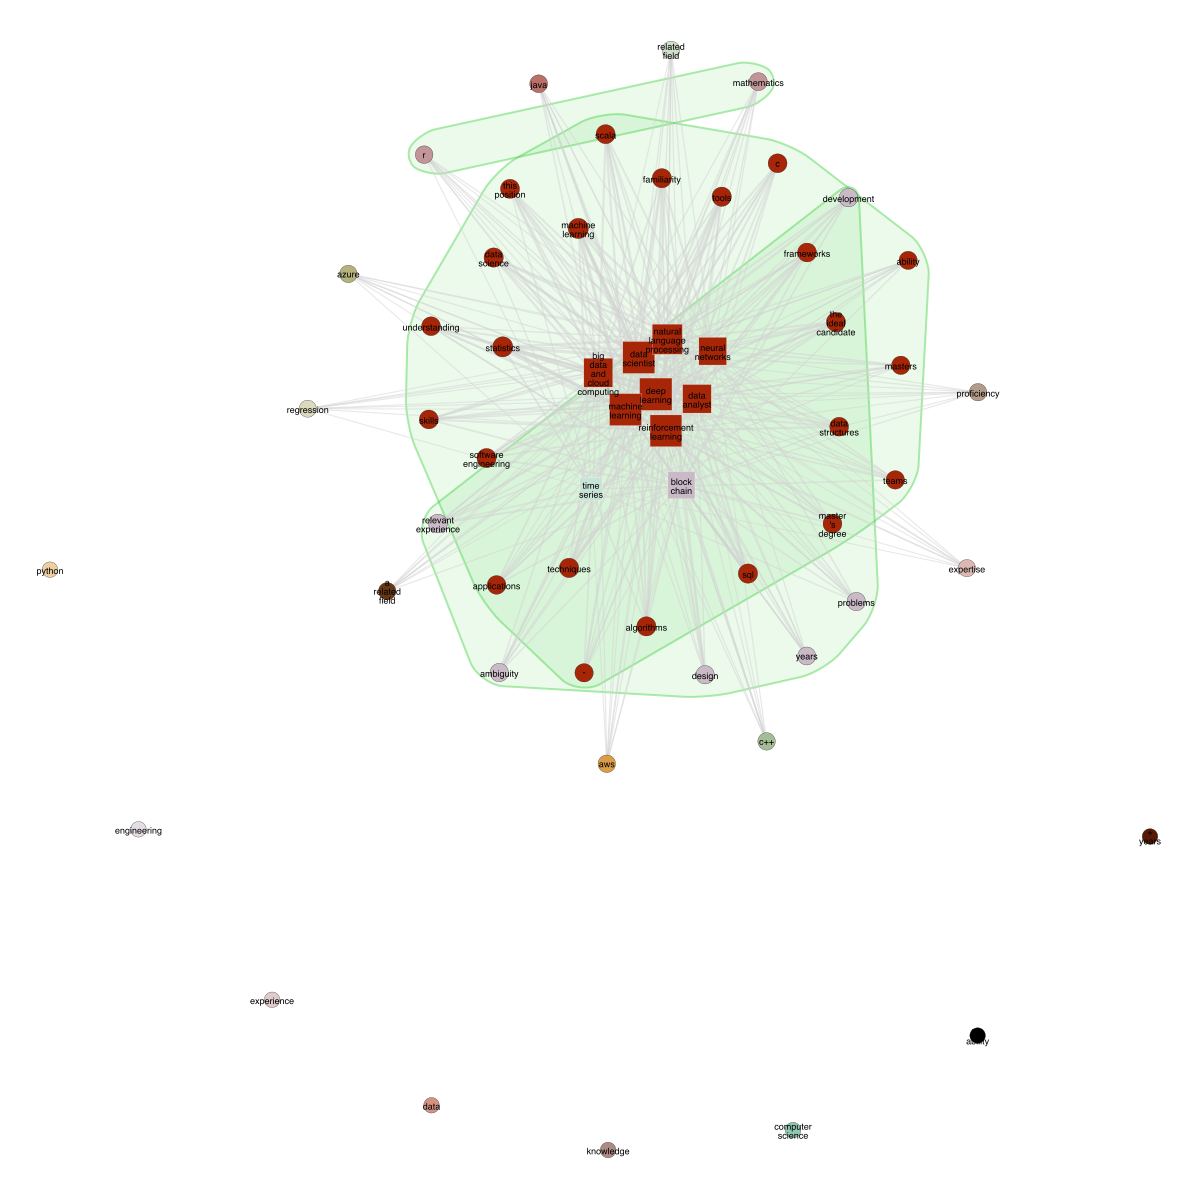

In [14]:
import textnets as tn
from textnets import Corpus
# Not separating time series and time series analysis changes it

tn.config.params['seed'] = 16

# Separate only the Qualifications and Category Columns
qualifications = agg[['Qualifications', 'category']]

# Expand each listed value in every row to a new row, with the same category
qualifications = qualifications.explode('Qualifications')

# Set the index column to be the category
qualifications = qualifications.set_index('category')

corpus = Corpus(qualifications['Qualifications'])

noun_phrases = corpus.noun_phrases()

#t = tn.Textnet(corpus.tokenized(), min_docs=8, remove_weak_edges=True)
t = tn.Textnet(noun_phrases, min_docs=8, remove_weak_edges=True)

tn.viz.BASE_COLORS = ['#A72608', '#CABAC8', '#C29598', '#B97068', '#581905', '#653715', '#DB9D47','#B6B27C','#A4BD97','#91C7B1']

# t.plot(label_nodes=True,
#        show_clusters=True,
#        color_clusters=True,
#        bbox=(1200, 1200),
#        scale_edges_by="weight",
#        scale_nodes_by="birank",
#        edge_opacity=0.5,
#         #target="term_network_4.png"
#         )



# t.plot(label_nodes=True,
#            scale_nodes_by="betweenness",
#            color_clusters=True,
#            alpha=0.5,
#            edge_width=[10*w for w in t.edges["weight"]],
#            edge_opacity=0.4,
#            node_label_filter=lambda n: n.betweenness() > t.betweenness.median())



In [43]:
from pyvis.network import Network
import textnets as tn
import networkx as nx
import igraph as ig
import leidenalg
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

# Set seed
random.seed(123)
np.random.seed(123)

# Function to get distinct colors
def get_color_list(num_colors):
    color_list = ['#EFB988', '#EB9486','#B58A90','#9A8595','#7E7F9A','#272838', '#8D8361', '#F3DE8A', '#BCBCC9', '#F9F8F8']
    return color_list[:num_colors]

corpus = tn.Corpus(qualifications['Qualifications'])
noun_phrases = corpus.noun_phrases()
t = tn.Textnet(noun_phrases, min_docs=8, remove_weak_edges=True)

# Convert the Textnet to an igraph.Graph object
igraph_graph = t.graph

# Apply the Leiden algorithm on the igraph graph
partition = leidenalg.find_partition(igraph_graph, leidenalg.RBConfigurationVertexPartition, seed=123)

# Convert the Textnet to a networkx.Graph object
nx_graph = t.graph.to_networkx()

# Create a mapping between node indices and community IDs
index_to_community_mapping = {v.index: partition.membership[v.index] for v in igraph_graph.vs}

# Update community information in the networkx graph
for node in nx_graph.nodes:
    node_index = nx_graph.nodes[node]['_igraph_index']
    nx_graph.nodes[node]['community_id'] = index_to_community_mapping[node_index]

# Get distinct colors for each community
num_communities = max([nx_graph.nodes[node]['community_id'] for node in nx_graph.nodes])
color_list = get_color_list(num_communities + 1)

# Remove unconnected nodes
connected_components = list(nx.connected_components(nx_graph))
largest_component = max(connected_components, key=len)
nx_graph = nx_graph.subgraph(largest_component).copy()

# Set node attributes for labels and community groupings
for node in nx_graph.nodes:
    if 'label' not in nx_graph.nodes[node]:
        nx_graph.nodes[node]['title'] = nx_graph.nodes[node]['id']
        nx_graph.nodes[node]['label'] = nx_graph.nodes[node]['id']
    else:
        nx_graph.nodes[node]['title'] = nx_graph.nodes[node]['label']
        nx_graph.nodes[node]['label'] = nx_graph.nodes[node]['label']
    
    node_type = nx_graph.nodes[node]['type']
    if node_type == 'doc':
        nx_graph.nodes[node]['shape'] = 'square'
    # else:
    #     nx_graph.nodes[node]['shape'] = 'circle'
    #     nx_graph.nodes[node]['size'] = 50
    
    # Set the color of the node based on its community ID
    community_id = nx_graph.nodes[node]['community_id']
    color = color_list[community_id]
    nx_graph.nodes[node]['color'] = color

# Create a Pyvis network and populate it with the nodes and edges from the networkx graph
nt = Network('800', width='100%', bgcolor='#272838', font_color='white', notebook=True)
nt.from_nx(nx_graph)

# Set physics and other configurations
nt.set_options("""
{
  "nodes": {
    "borderWidth": 3,
    "size": 60,
    "color": {
      "border": "rgba(0,0,0,1)"
    },
    "font": {
      "size": 20,
      "face": "tahoma"
    }
  },
  "edges": {
    "color": "darkgray",
    "smooth": false,
    "width": 1,
    "selectionWidth": 6
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -80000,
      "centralGravity": 0.3,
      "springLength": 225,
      "springConstant": 0.01,
      "damping": 0.09,
      "avoidOverlap": 5
    },
    "minVelocity": 0.75
  }
}
""")

# Display the interactive plot
# nt.show('./website/viz/textnet_qualifications.html')


/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:92: UserWarning:

Dropping 90 empty document(s).

/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:95: UserWarning:

There are 6815 duplicate labels. Concatenating documents.



  0%|          | 0/10 [00:00<?, ?docs/s]

./website/viz/textnet_qualifications.html


In [16]:
os.getcwd()

'/Users/bren/dsan-23-scholarship/miniproject'

/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:92: UserWarning: Dropping 104 empty document(s).
  warn(f"Dropping {missings} empty document(s).")
/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:95: UserWarning: There are 5583 duplicate labels. Concatenating documents.
  warn(f"There are {duplicated} duplicate labels. Concatenating documents.")


  0%|          | 0/10 [00:00<?, ?docs/s]

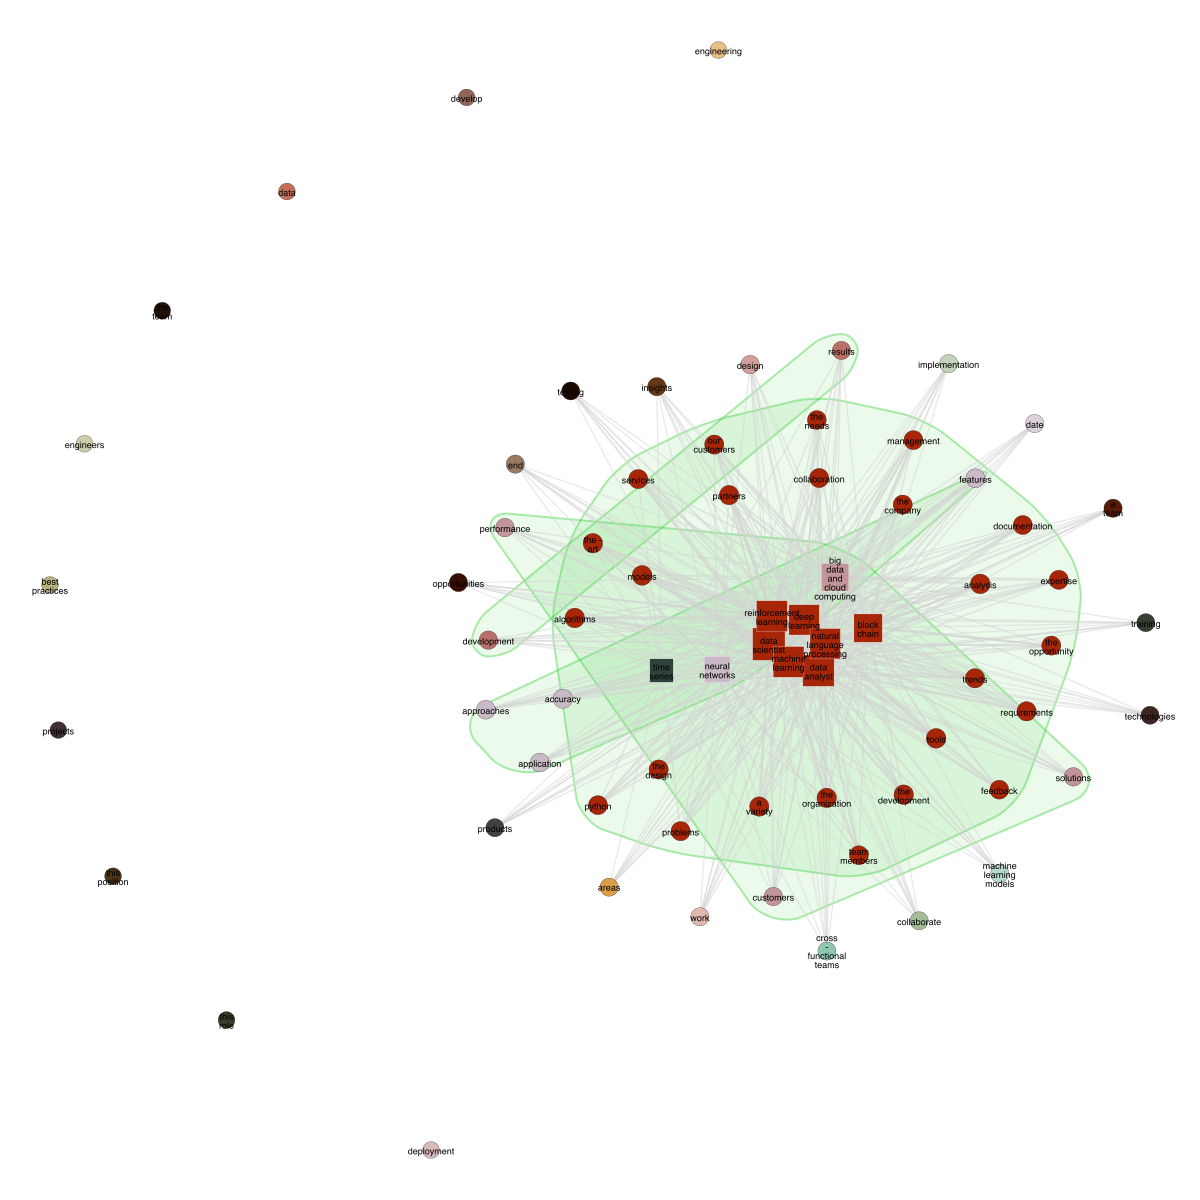

In [17]:
# Do the same as the Qualifications, but for Responsibilities
# Responsibilities
responsibilities = agg[['Responsibilities', 'category']]
responsibilities = responsibilities.explode('Responsibilities')
responsibilities = responsibilities.set_index('category')

corpus = Corpus(responsibilities['Responsibilities'])

noun_phrases = corpus.noun_phrases()

#t = tn.Textnet(corpus.tokenized(), min_docs=8, remove_weak_edges=True)
t = tn.Textnet(noun_phrases, min_docs=8, remove_weak_edges=True)
t.plot(label_nodes=True,
       show_clusters=True,
       color_clusters=True,
       bbox=(1200, 1200),
       scale_edges_by="weight",
       scale_nodes_by="birank",
       edge_opacity=0.5,
        #target="term_network_4.png"
        )



In [46]:
from pyvis.network import Network
import textnets as tn
import networkx as nx
import igraph as ig
import leidenalg
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

# Set seed
random.seed(123)
np.random.seed(123)

# Function to get distinct colors
def get_color_list(num_colors):
    color_list = ['#EFB988', '#EB9486','#B58A90','#9A8595','#7E7F9A','#272838', '#8D8361', '#F3DE8A', '#BCBCC9', '#F9F8F8']
    return color_list[:num_colors]

corpus = tn.Corpus(responsibilities['Responsibilities'])
noun_phrases = corpus.noun_phrases()
t = tn.Textnet(noun_phrases, min_docs=8, remove_weak_edges=True)

# Convert the Textnet to an igraph.Graph object
igraph_graph = t.graph

# Apply the Leiden algorithm on the igraph graph
partition = leidenalg.find_partition(igraph_graph, leidenalg.RBConfigurationVertexPartition, seed=123)

# Convert the Textnet to a networkx.Graph object
nx_graph = t.graph.to_networkx()

# Create a mapping between node indices and community IDs
index_to_community_mapping = {v.index: partition.membership[v.index] for v in igraph_graph.vs}

# Update community information in the networkx graph
for node in nx_graph.nodes:
    node_index = nx_graph.nodes[node]['_igraph_index']
    nx_graph.nodes[node]['community_id'] = index_to_community_mapping[node_index]

# Get distinct colors for each community
num_communities = max([nx_graph.nodes[node]['community_id'] for node in nx_graph.nodes])
color_list = get_color_list(num_communities + 1)

# Remove unconnected nodes
connected_components = list(nx.connected_components(nx_graph))
largest_component = max(connected_components, key=len)
nx_graph = nx_graph.subgraph(largest_component).copy()

# Set node attributes for labels and community groupings
for node in nx_graph.nodes:
    if 'label' not in nx_graph.nodes[node]:
        nx_graph.nodes[node]['title'] = nx_graph.nodes[node]['id']
        nx_graph.nodes[node]['label'] = nx_graph.nodes[node]['id']
    else:
        nx_graph.nodes[node]['title'] = nx_graph.nodes[node]['label']
        nx_graph.nodes[node]['label'] = nx_graph.nodes[node]['label']
    
    node_type = nx_graph.nodes[node]['type']
    if node_type == 'doc':
        nx_graph.nodes[node]['shape'] = 'square'
    # else:
    #     nx_graph.nodes[node]['shape'] = 'circle'
    #     nx_graph.nodes[node]['size'] = 50
    
    # Set the color of the node based on its community ID
    community_id = nx_graph.nodes[node]['community_id']
    color = color_list[community_id]
    nx_graph.nodes[node]['color'] = color

# Create a Pyvis network and populate it with the nodes and edges from the networkx graph
nt = Network('800', width='100%', bgcolor='#272838', font_color='white', notebook=True)
nt.from_nx(nx_graph)

# Set physics and other configurations
nt.set_options("""
{
  "nodes": {
    "borderWidth": 3,
    "size": 60,
    "color": {
      "border": "rgba(0,0,0,1)"
    },
    "font": {
      "size": 20,
      "face": "tahoma"
    }
  },
  "edges": {
    "color": "darkgray",
    "smooth": false,
    "width": 1,
    "selectionWidth": 6
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -80000,
      "centralGravity": 0.3,
      "springLength": 225,
      "springConstant": 0.01,
      "damping": 0.09,
      "avoidOverlap": 5
    },
    "minVelocity": 0.75
  }
}
""")

# Display the interactive plot
nt.show('./website/viz/textnet_responsibilities.html')
nt.save_graph('./website/viz/textnet_responsibilities.html')


/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:92: UserWarning:

Dropping 104 empty document(s).

/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/textnets/corpus.py:95: UserWarning:

There are 5583 duplicate labels. Concatenating documents.



  0%|          | 0/10 [00:00<?, ?docs/s]

./website/viz/textnet_responsibilities.html


In [19]:
# for node_id, node_index in id_to_index_mapping.items():
#     community = partition.membership[node_index]
#     nx_graph.nodes[node_id]['community_id'] = community

nx_graph.nodes[12]

{'type': 'term',
 'id': 'accuracy',
 '_igraph_index': 12,
 'community_id': 0,
 'title': 'accuracy',
 'label': 'accuracy',
 'color': '#EFB988',
 'size': 10}

In [20]:
# Find the group associated with each node of the textnet
t.top_cluster_nodes()

,nodes,size
cluster,,
0,"[data scientist, reinforcement learning, machi...",32
1,"[neural networks, accuracy, features, applicat...",5
2,"[big data and cloud computing, performance, cu...",4
3,"[development, results]",2
4,a team,1
5,insights,1
6,areas,1
7,best practices,1
8,collaborate,1


In [21]:
# See how many unique categories there are in the agg dataframe
agg['category'].value_counts()


block chain                     90
natural language processing     90
big data and cloud computing    90
data analyst                    90
machine learning                90
reinforcement learning          90
neural networks                 90
deep learning                   90
data scientist                  90
time series                     13
Name: category, dtype: int64

In [22]:
# Creating a bubble plot where the x axis is number of qualifications, the y axis is number of responsibilities, and the size of the bubble is the number of benefits (could also try jobs in that category)
# First, subset the data to get the number of qualifications, responsibilities, and benefits for each category
agg['num_qualifications'] = agg['Qualifications'].str.len()
agg['num_responsibilities'] = agg['Responsibilities'].str.len()
agg['num_benefits'] = agg['Benefits'].str.len()

# Subset the data to get the number of qualifications, responsibilities, and benefits for each category
agg_sub = agg[['category', 'num_qualifications', 'num_responsibilities', 'num_benefits', 'title', 'company_name','location']]

# Recode the NaNs in benefits to 0
agg_sub['num_benefits'] = agg_sub['num_benefits'].fillna(0)

/var/folders/dm/hqy2vyf53pj_9vry3bc0lwrc0000gn/T/ipykernel_62556/2267010748.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_sub['num_benefits'] = agg_sub['num_benefits'].fillna(0)


In [23]:
agg_sub.head()

,category,num_qualifications,num_responsibilities,num_benefits,title,company_name,location
0,block chain,6.0,5.0,0.0,Ethereum Blockchain Developer (Remote),Ex Populus,Anywhere
1,block chain,10.0,9.0,2.0,Blockchain Engineer,21.co,"New York, NY"
2,block chain,3.0,6.0,0.0,Blockchain Course Instructor,Blockchain Institute of Technology,Anywhere
3,block chain,1.0,1.0,0.0,Python based - Blockchain developer to join ex...,Upwork,Anywhere
4,block chain,4.0,8.0,0.0,Blockchain DevOps Engineer (Remote),Telnyx,United States


In [24]:
# Additional considerations here: show a minimum benefits
# What to do with ones that have no benefits?
# Consider the y axis goes to less than 0

import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import math

color_map = {
    'block chain': '#272838',
    'natural language processing': '#8D8361',
    'big data and cloud computing': "#F3DE8A",
    'machine learning': "#EFB988",
    'reinforcement learning': '#EB9486',
    'neural networks': '#B58A90',
    'deep learning': '#9A8595',
    'data scientist': '#7E7F9A',
    'time series analysis': '#BCBCC9',
    'time series': '#BCBCC9',
    'data analyst': '#F9F8F8',
}

# Reference for bubble size
size_ref = 2*max(agg_sub['num_benefits'])/(65**2)

# Create the viz lists
# 1 value true for all 11 categories
viz_lists = [[True if i == j else False for i in range(11)]for j in range(10)] 

# Initialize the figure
fig = go.Figure()

# Loop through each search term
for i, topic in enumerate(agg_sub['category'].unique()):
    # Filter the dataframe by household
    topic_df = agg_sub[agg_sub['category'] == topic]
    
    # Create the customdata for the hover text
    customdata = topic_df[['title', 'company_name', 'location','category', 'num_qualifications', 'num_responsibilities', 'num_benefits']]
    
    fig.add_trace(
        go.Scatter(
            x=topic_df['num_qualifications'],
            y=topic_df['num_responsibilities'],
            customdata=customdata,
            hovertemplate = '<b>%{customdata[0]}</b><br>Company: %{customdata[1]}<br>Location: %{customdata[2]}<br>Search term: %{customdata[3]}<extra></extra><br><br>Number of benefits: %{customdata[6]}',
            name=topic,
            mode = 'markers',
            marker_size = topic_df['num_benefits'],
            marker = dict(color = color_map[topic], sizemode = 'area', sizeref=size_ref, 
                           line_width=2, line_color='black'),
        )
    )

# Full custom hovertemplate:
#'<b>%{customdata[0]}</b><br>Company: %{customdata[1]}<br>Location: %{customdata[2]}<br>Search term: %{customdata[3]}<extra></extra><br>Number of qualifications: %{customdata[4]}<br>Number of responsibilities: %{customdata[5]}<br>Number of benefits: %{customdata[6]}


fig.update_layout(
    title='Number of Listed Qualifications Versus Number of Listed Responsibilities:<br><br><sup>The size of bubble represents the number of listed benefits - Mouse over a bubble for more info!</sup>',
    xaxis=dict(
        title='Number of Listed Qualifications',
        gridcolor='white',
        gridwidth=2,
    ),
    yaxis=dict(
        title='Number of Listed Responsibilities',
        gridcolor='white',
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    legend_title_text = 'Job Search Term',
    font=dict(size=16),
    height = 550
)


# Add a dropdown menu to filter by appliance
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            type='dropdown',
            showactive=True,
            buttons=[
                {'label': 'All Search Terms', 'method': 'update', 'args': [{'visible': True}, 
                                                              ]},
                {'label': 'Blockchain', 'method': 'update', 'args': [{'visible': viz_lists[0]}, ]},
                {'label': 'NLP', 'method': 'update', 'args': [{'visible': viz_lists[1]}, ]},
                {'label': 'Big Data', 'method': 'update', 'args': [{'visible': viz_lists[2]}, ]},
                {'label': 'Data Analyst', 'method': 'update', 'args': [{'visible': viz_lists[3]}, ]},
                {'label': 'Machine Learning', 'method': 'update', 'args': [{'visible': viz_lists[4]}, ]},
                {'label': 'Reinforcement Learning', 'method': 'update', 'args': [{'visible': viz_lists[5]}, ]},
                {'label': 'Neural Networks', 'method': 'update', 'args': [{'visible': viz_lists[6]}, ]},
                {'label': 'Deep Learning', 'method': 'update', 'args': [{'visible': viz_lists[7]}, ]},
                {'label': 'Data Scientist', 'method': 'update', 'args': [{'visible': viz_lists[8]}, ]},
                {'label': 'Time Series', 'method': 'update', 'args': [{'visible': viz_lists[9]}, ]}
            ],
        x = 0.7,
        xanchor = 'left',
        y = 1.21,
        yanchor = 'top',
        )
    ]
)

fig.update_layout(legend= {'itemsizing': 'constant'})
fig.show()



In [25]:
import plotly.express as px
df = agg_sub

fig = px.scatter(df, x="num_qualifications", y="num_responsibilities",
	         size="num_benefits",
                 hover_name="title", log_x=False, size_max=60)
fig.show()

In [26]:
# See how many NA salaries there are
agg['via'].value_counts()[1:15]

via ZipRecruiter        60
via Upwork              56
via AngelList           36
via Lever               23
via Greenhouse          19
via Clearance Jobs      19
via Startup Jobs        16
via Built In            15
via Salary.com          14
via Jobs By Workable    13
via Careers At Apple    13
via Karkidi             12
via Glassdoor           12
via Snagajob            12
Name: via, dtype: int64

In [27]:
# Quick plot to show number of benefits by via
agg_ben = agg[['via', 'num_benefits']]

# Show the number of benefits by via
agg_ben.groupby('via').mean().sort_values(by='num_benefits', ascending=False).head(15)

,num_benefits
via,
via Careers@Penn,17.00
via Caterpillar Careers,16.00
via Paylocity,11.00
via Abbott Jobs,10.00
via StartWire,10.00
"via Erias Ventures, LLC",10.00
via Wellfound,10.00
via EY Careers,9.00
via General Dynamics Information Technology,9.00


Salaries (range) vs hourly

In [28]:
# Subset the agg dataframe to only include the jobs that have a value for detected_extension_salary
agg_salary = agg[agg['detected_extension_salary'].notna()]


# Need to format salaries into multiple columns
# Split the salary into min and max on the - character
# Strip add hour or year from the end of the salary

data = agg_salary['detected_extension_salary']

# Replace non-breaking hyphen with a regular hyphen
data = agg_salary['detected_extension_salary'].str.replace('–', '-', regex=False)

# Regular expression to extract min, max, and time
pattern = r'(?P<min_salary>[0-9.]+[Kk]?)\s?(?:-\s?(?P<max_salary>[0-9.]+[Kk]?))?\s?(?P<time_interval>(an?\s(?:hour|year)))'

# Extracting the values and creating a DataFrame
df = data.str.extract(pattern)

# Convert K to 1000 for min and max columns
def convert_value(x):
    if isinstance(x, str) and x[-1].lower() == 'k':
        return float(x[:-1]) * 1000
    else:
        return float(x) if x is not None else None

df[['min_salary', 'max_salary']] = df[['min_salary', 'max_salary']].applymap(convert_value)
df['max_salary'].fillna(df['min_salary'], inplace=True)


# Drop the last column by index
df = df.drop(df.columns[3], axis=1)

# Merge this back with the original dataframe
agg_salary = pd.concat([agg_salary, df], axis=1)

df.head()

# 1 case not parsed correctly, edited manually.  2 montly salaries removed
#agg_salary.to_csv('./data/agg_salary.csv', index=False)

,min_salary,max_salary,time_interval
3,10.0,30.0,an hour
5,100000.0,200000.0,a year
7,150000.0,200000.0,a year
8,136000.0,146000.0,a year
1,53300.0,111000.0,a year


In [29]:
salary = pd.read_csv('./data/agg_salary.csv')

In [30]:
salary['location'].value_counts()

Anywhere                   51
United States               7
Seattle, WA                 6
Palo Alto, CA               5
Santa Clara, CA             4
San Francisco, CA           4
Sunnyvale, CA               4
Reston, VA                  4
Herndon, VA                 3
Boulder, CO                 3
Chicago, IL                 3
Boston, MA                  2
Irving, TX                  2
Beatrice, NE                2
Culver City, CA             2
San Jose, CA                2
Teaneck, NJ                 2
Chevy Chase, MD             2
Arlington, VA               2
Menlo Park, CA              2
Washington, DC              2
Lincolnshire, IL            1
Pasadena, CA                1
Dallas, TX                  1
Salt Lake City, UT          1
Charlotte, NC               1
Cary, NC                    1
New York, NY                1
Rockville, MD               1
Livermore, CA               1
South San Francisco, CA     1
Westborough, MA             1
Colorado Springs, CO        1
Ann Arbor,

In [31]:
import altair as alt

# # Melt the min_salary and max_salary columns into a single column
salary_long = pd.melt(salary, id_vars=['title', 'location','time_interval'], value_vars=['min_salary', 'max_salary'], var_name='salary_type', value_name='salary')


# Filter salary long so its only yearly salaries
salary_long = salary_long[salary_long['time_interval'] == 'a year']

alt.Chart(salary_long).mark_line().encode(
    x='salary_type:O',
    y='salary:Q',
    color='time_interval:N',
    detail = "title:N"
)

/Users/bren/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



alt.Chart(...)

In [32]:
from vega_datasets import data

source = data.barley()

source

,yield,variety,year,site
0,27.00000,Manchuria,1931,University Farm
1,48.86667,Manchuria,1931,Waseca
2,27.43334,Manchuria,1931,Morris
3,39.93333,Manchuria,1931,Crookston
4,32.96667,Manchuria,1931,Grand Rapids
...,...,...,...,...
115,58.16667,Wisconsin No. 38,1932,Waseca
116,47.16667,Wisconsin No. 38,1932,Morris
117,35.90000,Wisconsin No. 38,1932,Crookston
118,20.66667,Wisconsin No. 38,1932,Grand Rapids


In [33]:
data.population.url

'https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/population.json'